# 支付方式重要性排名模型

### Import libraries

In [2]:
import psycopg2
from psycopg2 import OperationalError
import numpy as np
from datetime import datetime, date, timedelta
from matplotlib import pyplot as plt
import pandas as pd
from tqdm.auto import tqdm, trange
from sklearn.metrics.pairwise import cosine_similarity
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

c:\Users\eeb02\.virtualenvs\final-fG7mChhK\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### SQL 連線

In [4]:
def sql_conn():
    conn = psycopg2.connect(
        host = '140.118.207.22',
        port = '5432',
        database = '91app',
        user = 'guest',
        password = '1',
    )

    return conn, conn.cursor()

## 1. 篩選出高貢獻的前20%會員


- SQL functions

In [ ]:
def create_conn():
    conn = None
    try:
        conn = psycopg2.connect(
            host="140.118.207.22",
            user="guest",
            password="1",
            database="91app",
            port="5432",
        )
        print("Connection to PostgreSQL DB successful")
    except OperationalError as e:
        print(f"The error '{e}' occurred")
    return conn

def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        print("Query executed successfully")
        return cursor.fetchall()
    except OperationalError as e:
        print(f"The error '{e}' occurred")       


In [ ]:
connection = create_conn()

- 讀取2021-01-01~2022-12-31的訂單資訊

In [ ]:
select_query = """
SELECT * 
FROM "Order" 
WHERE "OrderDateTime" >= '2021-01-01' AND "OrderDateTime" <= '2022-12-31'
"""

try:
    df = pd.read_sql_query(select_query, connection)
except Exception as e:
    print(f"The error '{e}' occurred")

- 去除包含StatusDef = Return的交易訂單
- 轉換OrderDateTime 成一般datetime格式，同時轉為UTC+8

In [ ]:
fail_return_codes = df[df['StatusDef'].isin(['Return'])]['TradesGroupCode'].unique()
data = df[(df['StatusDef'] == 'Finish') & (~df['TradesGroupCode'].isin(fail_return_codes))]
data = data[['ShopMemberId', 'OrderDateTime', 'TotalSalesAmount', 'StatusDef','TotalPrice','TotalPromotionDiscount','TotalCouponDiscount','TotalLoyaltyPointDiscount']]


data['OrderDateTime'] = data['OrderDateTime'] + timedelta(hours=8)
data['OrderDateTime'] = data['OrderDateTime'].dt.tz_convert(None)

print(data.info())

### 1-1. 把資料切成8等分，每次區間為3個月

- 抓出分割日期

In [ ]:
bin_dates = pd.date_range(start='2020-12-31', end='2022-12-31', freq='3M')
bin_dates = bin_dates + timedelta(days=1)

bin_dates = bin_dates.tolist()
print(bin_dates)

[Timestamp('2021-01-01 00:00:00'), Timestamp('2021-04-01 00:00:00'), Timestamp('2021-07-01 00:00:00'), Timestamp('2021-10-01 00:00:00'), Timestamp('2022-01-01 00:00:00'), Timestamp('2022-04-01 00:00:00'), Timestamp('2022-07-01 00:00:00'), Timestamp('2022-10-01 00:00:00'), Timestamp('2023-01-01 00:00:00')]


- 把data切成8分並存入df_intervals list

In [ ]:
df_intervals = []

for i in range(len(bin_dates)-1):
    start = bin_dates[i]
    end = bin_dates[i+1]
    df_intervals.append(data[(data['OrderDateTime'] >= start) & (data['OrderDateTime'] < end)])

- 建立 processed_intervals list，為8個區間的R(Recency)、F(Frequency)、M(Monetary)

In [ ]:
processed_intervals = []

for i in range(len(df_intervals)):
    df = df_intervals[i]
    end_date = bin_dates[i+1] 
    
    # 計算 Monetary、Frequency
    grouped_df = df.groupby('ShopMemberId').agg({'TotalSalesAmount':'sum', 
                                                  'OrderDateTime':'count'}).reset_index()
    grouped_df.rename(columns={'OrderDateTime': 'Frequency','TotalSalesAmount': 'Monetary'}, inplace=True)
    
    
    # 計算Recency
    max_date_df = df.groupby('ShopMemberId')['OrderDateTime'].max().reset_index()
    max_date_df['Recency'] = (end_date - max_date_df['OrderDateTime']).dt.days
    
    # 做merge
    cut_df = pd.merge(grouped_df, max_date_df[['ShopMemberId', 'Recency']], on='ShopMemberId', how='left')
    
    processed_intervals.append(cut_df)
    print(cut_df)

                                       ShopMemberId  Monetary  Frequency   
0      +0a6VFd3n3UA2rLwwT17sIwd9NrBPNtEzywulYcXR9I=    4024.0          1  \
1      +458PoYquuxvkXIfUgKUPg0IZbntFRTlCkPVuP7mEd0=    5130.0          2   
2      +458PoYquuxvkXIfUgKUPg5RRQHSJCkTH1hAd+T8lD0=    2080.0          1   
3      +458PoYquuxvkXIfUgKUPg7HG5qv58R7Yi1lE1Xgbcw=    8000.0          1   
4      +458PoYquuxvkXIfUgKUPgaG+H3C4nBZGB0VaIhL+1g=    2520.0          1   
...                                             ...       ...        ...   
59335  zr/JPzIrZ8jl1IxfFVxJcytmGMC3fBd1iA+gwnxQDPg=    1496.0          1   
59336  zr/JPzIrZ8jl1IxfFVxJczLhx0hK1xiUCbnrNq+6nKc=    1925.0          1   
59337  zr/JPzIrZ8jl1IxfFVxJczS5BKHf66v7DWcpcGKKFis=    2520.0          1   
59338  zr/JPzIrZ8jl1IxfFVxJczpS28O8ZtxX4eKQV7QPze8=   18541.0          3   
59339  zr/JPzIrZ8jl1IxfFVxJczuFBoNPHxxd/0xyznUBVGk=    8810.0          1   

       Recency  
0           45  
1           61  
2           44  
3           72  
4 

### 1-2. 訓練RFM model by k-means
1. 去除異常值 (後續還是會加回來做分析)
2. Train model
3. 最後把前20%的客戶抓出來

In [ ]:
#步驟1:去除異常值
#--------------------------------------------------
def remove_outliers_and_scale(train_data):
    Q1 = train_data[['Monetary']].quantile(0.25)
    Q3 = train_data[['Monetary']].quantile(0.75)
    IQR = Q3 - Q1

    upper_bound = Q3 + 2 * IQR

    
    #異常資料(後續還是會加回來)
    outlier_data = train_data[
        (train_data['Monetary'] > upper_bound['Monetary'])
    ]
    train_data = train_data[~train_data.index.isin(outlier_data.index)]
    
    #建立data_for_clustering(經標準化的train_data)
    features = ['ShopMemberId', 'Monetary', 'Frequency', 'Recency']
    data_for_clustering = train_data[features]

    scaler = MinMaxScaler()
    data_for_clustering[['Monetary', 'Recency']] = scaler.fit_transform(data_for_clustering[['Monetary','Recency']])

    return train_data,outlier_data,data_for_clustering

#步驟2:train kmeans Model並計算rfm分數
def clusterKmeans_and_score(train_data,data_for_clustering):
    #train k-means model
    train_data = train_data.copy()
    kmeans_model = KMeans(n_clusters=15, n_init='auto')
    kmeans_model.fit(data_for_clustering[['Monetary', 'Frequency', 'Recency']])

    cluster_labels = kmeans_model.labels_
    data_for_clustering['Cluster'] = cluster_labels
    train_data['Cluster'] = cluster_labels

    # 計算每個cluster的平均跟數量
    cluster_means = data_for_clustering.groupby('Cluster')[['Monetary', 'Frequency', 'Recency']].mean()
    cluster_counts = data_for_clustering.groupby('Cluster').size().reset_index(name='Count')
    cluster_means_sorted = cluster_means.merge(cluster_counts, on='Cluster')

    # 計算rfm分數
    scaler = MinMaxScaler()
    cluster_means_sorted['Frequency'] = scaler.fit_transform(cluster_means_sorted['Frequency'].values.reshape(-1,1))
    cluster_means_sorted['Recency'] = 1 - cluster_means_sorted['Recency']
    cluster_means_sorted['Score'] = cluster_means_sorted['Monetary']*1.5 + cluster_means_sorted['Frequency'] + cluster_means_sorted['Recency']

    return cluster_means_sorted, train_data


def get_important_customers(train_data,outlier_data, cluster_means_sorted):
    
    #加回異常值資料
    outlier_data = outlier_data.copy()
    outlier_data['Score'] = 99
    
    # 建立final_df (包括資料被分群的欄位跟rfm分數)
    final_df = pd.merge(train_data, cluster_means_sorted[['Cluster', 'Score']], on='Cluster', how='left')
    final_df = pd.concat([final_df, outlier_data], ignore_index=True)
    
    final_df = final_df.sort_values(by=['Score', 'Monetary'], ascending=False).reset_index(drop=True)
    final_df = final_df.drop(columns=['Score','Cluster'])

    # 找出前20%高貢獻客戶
    rfm_top_20_percent = int(0.2 * len(final_df))
    rfm_important_customers = final_df.iloc[:rfm_top_20_percent]
    
    
    return rfm_important_customers




- 抓出8個月間的important_customers

In [ ]:
important_customers_list = []
origin_data_list = []

i = 1
for train_data in processed_intervals:
    end_date = bin_dates[i]
    i+=1
    #train_data為原資料 #data_for_clustering為要做分群的資料(通過標準化)
    train_data,outlier_data,data_for_clustering = remove_outliers_and_scale(train_data)
    
    #train k-means model
    cluster_means_sorted, train_data = clusterKmeans_and_score(train_data,data_for_clustering)
    origin_data_list.append(train_data)
    
    #透過rfm score找出前20%重要客戶
    important_customers = get_important_customers(train_data, outlier_data,cluster_means_sorted)
    important_customers_list.append(important_customers)


- 劃出分群結果

In [ ]:
#%matplotlib qt5
def visualize_clusters_multiple(origin_data_list):
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'brown', 'pink', 'gray', 'olive', 'teal', 'navy', 'lime']

    for i, data_for_clustering in enumerate(origin_data_list):
        cluster_counts = data_for_clustering['Cluster'].unique()
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        for cluster in cluster_counts:
            cluster_data = data_for_clustering[data_for_clustering['Cluster'] == cluster]
            # Sample 1/10 of the cluster data
            sampled_data = cluster_data.sample(frac=0.1, random_state=1)
            
            ax.scatter(sampled_data['Monetary'], sampled_data['Frequency'], sampled_data['Recency'], c=colors[cluster], label=f'Cluster {cluster}')


        ax.set_xlabel('Monetary')
        ax.set_ylabel('Frequency')
        ax.set_zlabel('Recency')
        ax.invert_yaxis()
        ax.legend(loc='upper left')
        plt.title(f'Interval #{i+1}')
        plt.show()


visualize_clusters_multiple(origin_data_list)

- 抓出8個區間前 20%高貢獻的客戶ShopMemberId

In [ ]:
# Concatenate 'ShopMemberId' columns from all dataframes in the list
all_shop_member_ids = pd.concat([df['ShopMemberId'] for df in important_customers_list])

# Get unique values
unique_shop_member_ids = all_shop_member_ids.unique()
print(len(unique_shop_member_ids))

58715


- 取出Member資料，儲存前20%高貢獻客戶的資料

In [ ]:
select_query = """
SELECT * 
FROM "Member" 
"""

try:
    member_df = pd.read_sql_query(select_query, connection)
except Exception as e:
    print(f"The error '{e}' occurred")

C:\Users\Ching\AppData\Local\Temp\ipykernel_3412\1331252583.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  member_df = pd.read_sql_query(select_query, connection)


In [ ]:
# 從data DataFrame中選擇出與important_client_data中出現的客戶訂單
important_client_data = member_df[member_df['ShopMemberId'].isin(unique_shop_member_ids)]
important_client_data = important_client_data[['ShopMemberId','Gender','Birthday','MemberCardLevel','CountryAliasCode']]
important_client_data = important_client_data.set_index('ShopMemberId')
print(len(important_client_data))

58715


- 儲存結果

In [ ]:
important_client_data.to_pickle('./vip_list.pkl', compression='zip')

In [ ]:
# 關閉連線
connection.close()

## 2. "高貢獻"與"其他會員" 的消費高峰區間
計算高貢獻會員與其他會員在每個區間的消費額。
根據2021-1-1 ~ 2022-12-31，區間窗口為14天，每次滑動5天。
獲得(1,143)的向量，經正規化後，計算consine similarity，分析高貢獻和其他會員的偏好消費區間相似度。

- 讀取VIP名單

In [9]:
conn, cursor = sql_conn()
vip_df = pd.read_pickle('./vip_list.pkl', compression='zip')

- 從資料庫取出訂單資訊，計算每個窗口的訂單金額

In [10]:
st_date = date(2021,1,1)        # 設定起始日期
final_date = date(2022,12,15)   # 終止日期
results = list()

while st_date <= final_date:
    end_date = st_date + timedelta(days=14)  # 窗口大小設為14天
    sql_query = 'select "TotalSalesAmount", "ShopMemberId" from "Order" where "OrderDateTime" >= %s and "OrderDateTime" < %s'
    cursor.execute(sql_query, (st_date.isoformat(), end_date.isoformat()))  # 從DB取出資料
    
    rows = cursor.fetchall()
    vip_total = 0.0
    other_total = 0.0
    
    for row in tqdm(rows):
        if row[1] in vip_df.index:  # 如果為VIP
            vip_total += row[0]     # 累加區間內高貢獻總訂單金額
        else:
            other_total += row[0]   # 累加區間內其他總訂單金額
    
    results.append(("{:s} ~ {:s}".format(st_date.isoformat(), end_date.isoformat()), st_date.isoformat(), end_date.isoformat(), vip_total, other_total))
    st_date += timedelta(days=5)    # 窗口每次滑移5天

100%|██████████| 15682/15682 [00:00<00:00, 747571.46it/s]


- 轉換為DataFrame

In [11]:
result_pd = pd.DataFrame(results, columns=['Period', 'Start_date', 'End_data', 'VIP_total', 'Other_total'])
result_pd.to_pickle('./peak.pkl', compression='zip')
# result_pd = pd.read_pickle('./peak.pkl', compression='zip')
result_pd.head()

,Period,Start_date,End_data,VIP_total,Other_total
0,2021-01-01 ~ 2021-01-15,2021-01-01,2021-01-15,22430988.0,36920098.0
1,2021-01-06 ~ 2021-01-20,2021-01-06,2021-01-20,18247677.0,28098444.0
2,2021-01-11 ~ 2021-01-25,2021-01-11,2021-01-25,17868461.0,25504701.0
3,2021-01-16 ~ 2021-01-30,2021-01-16,2021-01-30,20742269.0,27603568.0
4,2021-01-21 ~ 2021-02-04,2021-01-21,2021-02-04,25956810.0,31810092.0


- 將消費高峰數據轉換為向量，經正規化後，計算相似度

In [13]:
# 找出最大值
vip_base = result_pd['VIP_total'].iloc[result_pd['VIP_total'].argmax()]
normal_base = result_pd['Other_total'].iloc[result_pd['Other_total'].argmax()]

# 正規化
result_pd['VIP_total_N'] = result_pd['VIP_total'].apply( lambda x: x/vip_base )
result_pd['Other_total_N'] = result_pd['Other_total'].apply( lambda x: x/normal_base )

# 轉換為向量 (1, 143)
vip_peak_vec = result_pd['VIP_total_N'].to_numpy()
normal_peak_vec = result_pd['Other_total_N'].to_numpy()
simi = cosine_similarity(vip_peak_vec.reshape(1,143), normal_peak_vec.reshape(1,143))
print('消費高峰相似度: ', simi[0][0])

消費高峰相似度:  0.9239615460344095


### 2-1. 計算每位會員平均使用的支付種類數

In [14]:
'''
引入SelectionFlow.py的計算結果，
'payment.pkl' (計算期間每位會員使用的支付次數)。
'''
pay_df = pd.read_pickle('./payment.pkl', compression='zip')

In [15]:
def countPayment(series):
    count = 0
    for i in series.index:
        if series[i] > 0 and i != 'Offline':  # 排除線下
            count += 1
    return count

# 計算每位會員共使用幾種支付方式
pay_df['CountPayment'] = pay_df.apply(countPayment, axis=1)

membercount = 0
for c in pay_df['CountPayment']:
    if c > 0:
        membercount += 1

In [16]:
# 計算平均使用的支付種類
avg_pay = pay_df['CountPayment'].sum()/membercount
print('{:.2f} 種/人'.format(avg_pay))

1.21 種/人


- 支付方式使用次數排名

In [17]:
# 支付方式排名
payment = dict()

for i in pay_df.columns:
    payment[i] = pay_df[i].sum()
    
print(payment)    

# 排序
payment_sort = sorted(payment.items(), key=lambda x: x[1])
print(payment_sort[::-1])

{'CreditCardOnce': 66457, 'CreditCardInstallment': 36984, 'ATM': 13862, 'Family': 0, 'SevenEleven': 0, 'ApplePay': 13400, 'LinePay': 29924, 'GooglePay': 109, 'JKOPay': 6389, 'Aftee': 8250, 'Atome': 476, 'EasyWallet': 1121, 'FreeOfCharge': 2, 'Offline': 401454, 'CountPayment': 86772}
[('Offline', 401454), ('CountPayment', 86772), ('CreditCardOnce', 66457), ('CreditCardInstallment', 36984), ('LinePay', 29924), ('ATM', 13862), ('ApplePay', 13400), ('Aftee', 8250), ('JKOPay', 6389), ('EasyWallet', 1121), ('Atome', 476), ('GooglePay', 109), ('FreeOfCharge', 2), ('SevenEleven', 0), ('Family', 0)]


### 2-2. 高貢獻會員貢獻金額占比
貢獻金額可以作為名單品質的指標  
- 計算高貢獻會員人數比

In [19]:
'''
'payment.pkl' (計算期間每位會員使用的支付次數)，
也等同於其間有消費過的會員名單。
'''
total_member = len(pay_df.index)

cursor.execute('select count(*) from "VIP"; ')
[(total_vip,)] = cursor.fetchall() 

print('高貢獻會員占比: {:.2f}%'.format(total_vip/total_member*100))

高貢獻會員占比: 21.18%


- 計算高貢獻會員的消費金額占比  
- 同時存下高貢獻會員期間內的所有訂單

In [26]:
# sql 語句，取出訂單資料
sql_query = 'select "ShopMemberId", "TotalSalesAmount", "TotalPrice", "TotalDiscount", "PaymentType", "TsCount" from "Order" \
    where "OrderDateTime" >= %s and "OrderDateTime" < %s'
cursor.execute(sql_query, ('2021-1-1', '2023-1-1'))

rows = cursor.fetchall()
vip_orders = list()
vip_total = 0.0
sales_total = 0.0

for row in tqdm(rows):
    sales_total += row[1]       # 累加金額
    if row[0] in vip_df.index:
        vip_total += row[1]     # 累加金額
        vip_orders.append(row)

print('高貢獻會員消費占比: {:.2f}%'.format(vip_total/sales_total*100))

# 轉換成DataFrame並儲存
vip_orders_df = pd.DataFrame(vip_orders, columns=["ShopMemberId", "TotalSalesAmount", "TotalPrice", "TotalDiscount", "PaymentType", "TsCount"])  
vip_orders_df.to_pickle('./vip_orders.pkl', compression='zip')

100%|██████████| 578428/578428 [00:00<00:00, 674147.99it/s]


高貢獻會員消費占比: 50.97%


## 3. 會員等級的轉換率
- 讀出vip list

In [27]:
vip_df = pd.read_pickle('./vip_list.pkl', compression='zip')

- 計算各等級會員占比

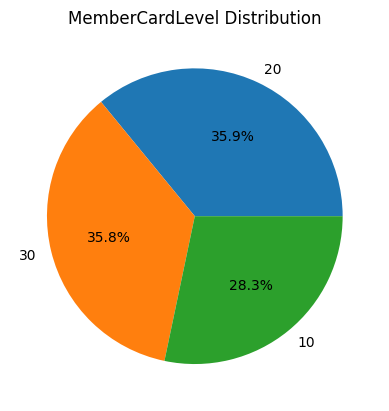

In [28]:
vip_proportion = vip_df['MemberCardLevel'].value_counts()
vip_proportion.plot(kind='pie', autopct='%1.1f%%')
plt.title('MemberCardLevel Distribution')
plt.ylabel('')
plt.show()

- 讀出vip orders

In [29]:
vip_orders_df = pd.read_pickle('./vip_orders.pkl', compression='zip')

- 使用額外欄位紀錄每筆訂單來自何種等級之會員

In [30]:
def levelValue(series):
    if vip_df.loc[series['ShopMemberId']]['MemberCardLevel'] == 30:
        series['On_30'] = series['TotalSalesAmount']
    elif vip_df.loc[series['ShopMemberId']]['MemberCardLevel'] == 20:
        series['On_20'] = series['TotalSalesAmount']
    else:
        series['On_10'] = series['TotalSalesAmount']
        
    return series


vip_orders_df = vip_orders_df.apply(levelValue, axis=1)

- 印出資訊

In [31]:
total_sales = vip_orders_df["TotalSalesAmount"].sum()
total_30 = vip_orders_df["On_30"].sum()
total_20 = vip_orders_df["On_20"].sum()
total_10 = vip_orders_df["On_10"].sum()

print("Level 30: ${:.0f} / {:.2f}%".format(total_30, total_30/total_sales*100))
print("Level 20: ${:.0f} / {:.2f}%".format(total_20, total_20/total_sales*100))
print("Level 10: ${:.0f} / {:.2f}%".format(total_10, total_10/total_sales*100))

print("Level 30 transfer: {:.2f}".format(total_30/total_sales*100/35.9))
print("Level 20 transfer: {:.2f}".format(total_20/total_sales*100/35.8))
print("Level 10 transfer: {:.2f}".format(total_10/total_sales*100/25.3))

Level 30: $711500179 / 59.35%
Level 20: $338706418 / 28.25%
Level 10: $148620545 / 12.40%
Level 30 transfer: 1.65
Level 20 transfer: 0.79
Level 10 transfer: 0.49


## 4. 對每筆訂單銷售金額加權計算
我們假設:  
支付方式的手續費，消費者身分(會員等級)，使用折扣比和購買種類數，  
能夠讓我們找到貢獻度最高的支付方式。

### 4-1. 參數設定
- 設定各支付方式的金流手續費

In [32]:
fees = {
    'ApplePay': 0.0275,
    'LinePay': 0.03,
    'CreditCardOnce': 0.0275,
    'CreditCardInstallment': 0.035,
    'ATM': 0.01,
    'Family': -15,  # < 0 表示為逐筆收定額
    'SevenEleven': -15,
    'GooglePay': 0.0275,
    'JKOPay': 0.022,
    'Aftee': 0.025,
    'Atome': 0.06,
    'EasyWallet': 0,
    'FreeOfCharge': 0,
    'Offline': 0,
}

- 設定權重

In [33]:
weight = {
    'Level30': 1.6,
    'Level20': 1.2,
    'TsCount_threshold': 3.5,   # 設定商品種類閥值
    'TsCount_bias': 1.2,        # 超過閥值，才加權
    'Discount_bias': 1.2,
    'fee_bias': 5,
}

### 4-2. 計算加權金額
- 定義加權算法

In [34]:
def calWeightedSales(series, members_df):
    # 會員等級
    if members_df.loc[series['ShopMemberId']]['MemberCardLevel'] == 30:
        level_weight = weight['Level30']
    elif members_df.loc[series['ShopMemberId']]['MemberCardLevel'] == 20:
        level_weight = weight['Level20']
    else:
        level_weight = 1.0
    
    # 金流手續費    
    fee = fees.get(series['PaymentType'], None)
    if fee != None:
        fee_weight = 1 - (fee * weight['fee_bias'])
    else:
        fee_weight = 1.0
    
    # 不重複商品種類   
    if series['TsCount'] > weight['TsCount_threshold']:
        ts_weight = weight['TsCount_bias']
    else:
        ts_weight = 1.0
    
    # 折扣比例    
    if series['TotalPrice'] != 0:
        discount_weight = series['TotalSalesAmount'] / series['TotalPrice'] * weight['Discount_bias']
    else:
        discount_weight = 0
        
    return series['TotalSalesAmount'] * level_weight * fee_weight * ts_weight * discount_weight

- 計算加權金額

In [35]:
vip_orders_df['WeightedTotalSales'] = vip_orders_df.apply(lambda x: calWeightedSales(x,vip_df), axis=1)
vip_orders_df.head()

,On_10,On_20,On_30,PaymentType,ShopMemberId,TotalDiscount,TotalPrice,TotalSalesAmount,TsCount,WeightedTotalSales
0,NaN,NaN,5900.0,None,8UznbMg+eOSRlkBLXLS84s2XcK4BWu3L4+aB46m58WI=,0.0,5900.0,5900.0,1,11328.000000
1,NaN,NaN,5900.0,None,Cl8xkthmsayjNnyDLopM4JnK4ISxfa1K3gn3wac/rY0=,0.0,5900.0,5900.0,1,11328.000000
2,1900.0,NaN,NaN,None,rxpBkm3xQryMLO9erBk/ILg0Nr2YwW6m1cIwaA3zM00=,-2600.0,4500.0,1900.0,1,962.666667
3,6500.0,NaN,NaN,None,Tklm188Ah5+43gId8WMWUzkm7Q8qmi7tvH813V3NL+M=,0.0,6500.0,6500.0,1,7800.000000
4,NaN,NaN,1050.0,None,SREGrQPQz2SwWBj1UfEsh3TVGI3Rc6sHIYDDUqnOkj4=,-450.0,1500.0,1050.0,1,1411.200000


- 支付方式排名

In [36]:
# 去除多餘欄位
test_df = vip_orders_df.drop(columns=['On_10', 'On_20', 'On_30', 'TotalDiscount', 'TotalPrice', 'ShopMemberId', 'TsCount'])
# 分群
test = test_df.groupby(by=['PaymentType'], dropna=False).mean()
print(test.sort_values(by=['WeightedTotalSales'], ascending=False))
print(test.sort_values(by=['TotalSalesAmount'], ascending=False))

                       TotalSalesAmount  WeightedTotalSales
PaymentType                                                
NaN                         5514.127028         7291.344682
CreditCardInstallment       3469.132255         4519.657663
Atome                       3628.721154         4259.945210
GooglePay                   2936.369565         4234.192557
ATM                         2772.001262         4124.744210
Aftee                       2997.472689         4007.423753
EasyWallet                  2440.827506         3651.278806
CreditCardOnce              2653.797856         3509.213315
JKOPay                      2640.372603         3508.885318
ApplePay                    2602.545105         3467.968441
LinePay                     2589.094172         3342.380334
FreeOfCharge                   0.000000            0.000000
                       TotalSalesAmount  WeightedTotalSales
PaymentType                                                
NaN                         5514.127028 

### 4-3. 計算全體加權金額
- 取得所有訂單資訊和會員資訊

In [37]:
# 使用sql語句取出
all_orders_df = pd.read_sql_query('select "ShopMemberId", "TotalSalesAmount", "TotalPrice", "TotalDiscount", "PaymentType", "TsCount" from "Order" \
    where "OrderDateTime" >= %s and "OrderDateTime" < %s', conn, params=('2021-1-1', '2023-1-1'))

all_users_df = pd.read_sql_query('select "ShopMemberId", "Gender", "Birthday", "MemberCardLevel", "CountryAliasCode" from "Member" \
        where "Member"."RegisterDateTime"<%s', conn, index_col='ShopMemberId', params=('2023-1-1',))

C:\Users\eeb02\AppData\Local\Temp\ipykernel_17804\118511248.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  all_orders_df = pd.read_sql_query('select "ShopMemberId", "TotalSalesAmount", "TotalPrice", "TotalDiscount", "PaymentType", "TsCount" from "Order" \
C:\Users\eeb02\AppData\Local\Temp\ipykernel_17804\118511248.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  all_users_df = pd.read_sql_query('select "ShopMemberId", "Gender", "Birthday", "MemberCardLevel", "CountryAliasCode" from "Member" \


- 計算全體訂單的加權金額
- 支付方式排名

In [38]:
all_orders_df['WeightedTotalSales'] = all_orders_df.apply(lambda x: calWeightedSales(x, all_users_df), axis=1)
test2_df = all_orders_df.drop(columns=['TotalDiscount', 'TotalPrice', 'ShopMemberId', 'TsCount'])
test2 = test2_df.groupby(by=['PaymentType'], dropna=False).mean()
print(test2.sort_values(by=['WeightedTotalSales'], ascending=False))
print(test2.sort_values(by=['TotalSalesAmount'], ascending=False))

                       TotalSalesAmount  WeightedTotalSales
PaymentType                                                
NaN                         4723.324560         5577.111512
CreditCardInstallment       3088.132057         3580.665866
GooglePay                   2768.082569         3403.619736
Aftee                       2867.464485         3370.940432
Atome                       3373.779412         3355.318921
ATM                         2566.678690         3333.536806
EasyWallet                  2371.844781         3049.685195
ApplePay                    2385.869179         2861.672170
CreditCardOnce              2402.153829         2795.102340
JKOPay                      2376.194710         2758.355993
LinePay                     2373.130330         2673.679214
FreeOfCharge                   0.000000            0.000000
                       TotalSalesAmount  WeightedTotalSales
PaymentType                                                
NaN                         4723.324560 

### 4-4. 正規化並計算相似度
將高貢獻和全體的支付方式排名向量化，求相似度

In [39]:
vip_vec = (test.sort_values(by=['WeightedTotalSales'], ascending=False))['WeightedTotalSales'].to_numpy()
all_vec = (test2.sort_values(by=['WeightedTotalSales'], ascending=False))['WeightedTotalSales'].to_numpy()

vip_vec_norm = vip_vec / np.linalg.norm(vip_vec)
all_vec_norm = all_vec / np.linalg.norm(all_vec)
print(vip_vec_norm)
print(all_vec_norm)
print('相似度: ', cosine_similarity(vip_vec_norm.reshape(1,12), all_vec_norm.reshape(1,12))[0])

[0.51062579 0.31651964 0.29833151 0.29652801 0.28886315 0.28064699
 0.25570553 0.24575643 0.24573346 0.24286798 0.23407282 0.        ]
[0.4904611  0.31489012 0.29932037 0.29644649 0.29507271 0.29315715
 0.26819474 0.25166054 0.24580627 0.24257473 0.2351281  0.        ]
相似度:  [0.99960132]


## 關閉SQL連線

In [40]:
cursor.close()
conn.close()

## 5. 支付方式的影響 (假設應用情境)
基於上面的結果，我們得出"Atome", "信用卡分期"的支付方式是潛在有高貢獻的支付方式。  
我們假設:  
在2022年末，業主使用本模型後，想要降低金流手續費，  
剛好91app有跟Aftee合作，希望能轉移分期的需求至該支付方式，預計轉移25%。  
  
使用至今都未窺看過的2023年後資料帶入。  
實驗如果成功轉移25%的分期需求，可為業主增加多少收入。


- 取出2023年後訂單資訊

In [6]:
conn, cursor = sql_conn()
new_orders_df = pd.read_sql_query('select "TotalSalesAmount", "PaymentType" from "Order" where "OrderDateTime" >= %s', conn, params=('2023-1-1',))

C:\Users\eeb02\AppData\Local\Temp\ipykernel_29088\1377232739.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  new_orders_df = pd.read_sql_query('select "TotalSalesAmount", "PaymentType" from "Order" where "OrderDateTime" >= %s', conn, params=('2023-1-1',))


- 假設成功轉移25%

In [7]:
transfer_ratio = 0.25

- 設定金流手續費

In [8]:
fees = {
    'CreditCardInstallment': 0.035,
    'Aftee': 0.025,
    'Atome': 0.06,
}

- 計算"刷卡分期"和"Atome"的訂單總金額

In [9]:
tmp_df = new_orders_df.groupby('PaymentType').sum()
print(tmp_df)

                       TotalSalesAmount
PaymentType                            
ATM                           3558541.0
Aftee                         2215205.0
ApplePay                      3045113.0
CreditCardInstallment        13769350.0
CreditCardOnce               17228643.0
EasyWallet                     730813.0
GooglePay                       84270.0
JKOPay                        1636980.0
LinePay                       8155681.0


- 意外發現在2023年無"Atome"訂單

In [10]:
try:
    cci_total = tmp_df.loc['CreditCardInstallment']['TotalSalesAmount']
except:
    cci_total = 0
    
try:    
    atome_total = tmp_df.loc['Atome']['TotalSalesAmount']
except:
    atome_total = 0
    
print("刷卡分期訂單金額: $", int(cci_total))
print("Atome訂單金額: $", atome_total)

刷卡分期訂單金額: $ 13769350
Atome訂單金額: $ 0


- 計算毛利增減

In [11]:
revenue = (cci_total * (fees['CreditCardInstallment'] - fees['Aftee']) * transfer_ratio) + (atome_total * (fees['Atome'] - fees['Aftee']) * transfer_ratio)
print('期間營業額增減: ${:.1f}'.format(revenue))

期間營業額增減: $34423.4


- 關閉連線

In [12]:
cursor.close()
conn.close()